## Práctico 5 - Aprendizaje automático

### Parte 1: Aprendizaje supervisado. CSV: `Estrellas`

#### Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Para mostrar el arbol de decision
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
from IPython.display import Image  
import pydotplus

1. Preprocesar preprocesar los datos, dividirlos en conjuntos de entrenamiento, validación y testeo y normalizar los mismos.

In [2]:
# Leer csv de Estrellas para mi parte 1
estrellas = pd.read_csv('estrellas.csv')
print(estrellas.head())

#  Evaluar datos faltantes
print(estrellas.isnull().sum())

   Temperature (K)  Luminosity (L/Lo)  Radius (R/Ro)  Absolute magnitude (Mv)  \
0             3068           0.002400         0.1700                    16.12   
1             3042           0.000500         0.1542                    16.60   
2             2600           0.000300         0.1020                    18.70   
3             2800           0.000200         0.1600                    16.65   
4             1939           0.000138         0.1030                    20.06   

   Star type Star category Star color Spectral Class  
0          0   Brown Dwarf        Red              M  
1          0   Brown Dwarf        Red              M  
2          0   Brown Dwarf        Red              M  
3          0   Brown Dwarf        Red              M  
4          0   Brown Dwarf        Red              M  
Temperature (K)            0
Luminosity (L/Lo)          0
Radius (R/Ro)              0
Absolute magnitude (Mv)    0
Star type                  0
Star category              0
Star colo

/var/folders/jt/6ym0xyt517bbzlyfmnhg34jc0000gn/T/ipykernel_51737/2796520990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=estrellas, x='Star category', y='Absolute magnitude (Mv)', palette="muted" )


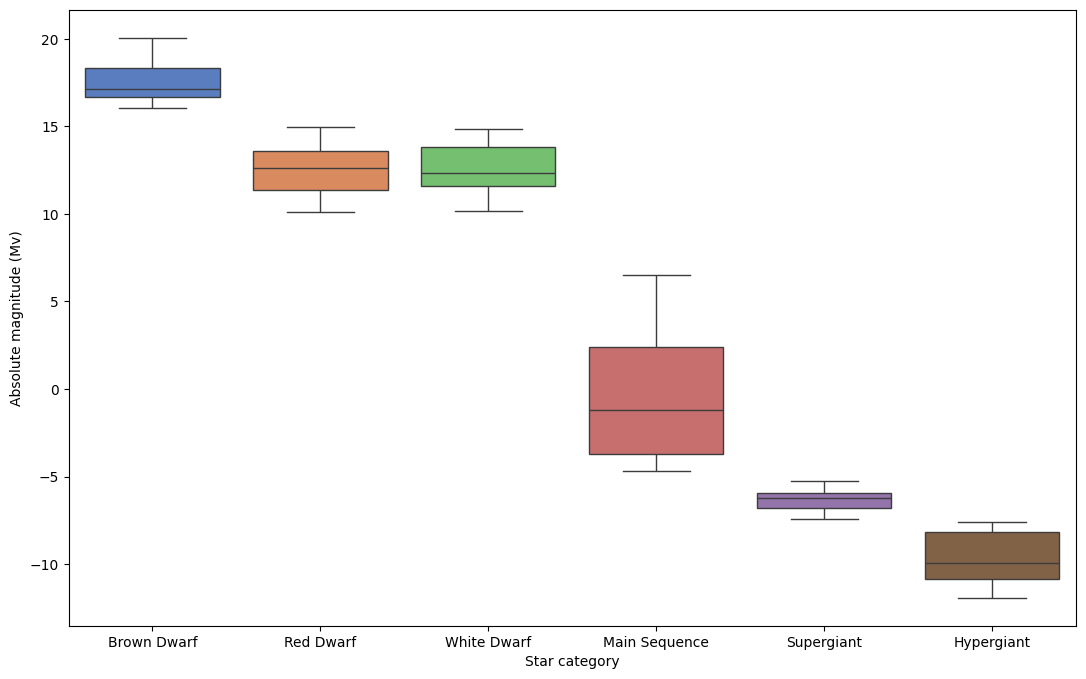

In [3]:
plt.figure(figsize=(13,8))
sns.boxplot(data=estrellas, x='Star category', y='Absolute magnitude (Mv)', palette="muted" )
plt.show()

In [4]:
# Vemos los valores únicos de cada columna
print(f'Star type valores únicos: {estrellas['Star type'].unique()}')
print(f'Star category valores únicos: {estrellas['Star category'].unique()}')
print(f'Star color valores únicos: {estrellas['Star color'].unique()}')
print(f'Spectral Class valores únicos: {estrellas['Spectral Class'].unique()}')

Star type valores únicos: [0 1 2 3 4 5]
Star category valores únicos: ['Brown Dwarf' 'Red Dwarf' 'White Dwarf' 'Main Sequence' 'Supergiant'
 'Hypergiant']
Star color valores únicos: ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
Spectral Class valores únicos: ['M' 'B' 'A' 'F' 'O' 'K' 'G']


In [5]:
# Como la temperatura y la categoría ya me las categorizan, el color no nos aporta información extra
estrellas = estrellas.drop(columns=['Star color'])
print(estrellas.columns)
print(estrellas.isnull().sum())

Index(['Temperature (K)', 'Luminosity (L/Lo)', 'Radius (R/Ro)',
       'Absolute magnitude (Mv)', 'Star type', 'Star category',
       'Spectral Class'],
      dtype='object')
Temperature (K)            0
Luminosity (L/Lo)          0
Radius (R/Ro)              0
Absolute magnitude (Mv)    0
Star type                  0
Star category              0
Spectral Class             0
dtype: int64


> Quiero ver si se puede eliminar otra columna. A grandes rasgos pareciera que Star Category y Star Type son las mismas con diferentes referencias, pero para confirmarlo podríamos mapear una de ellas y calcular la correlación entre ambas.

In [6]:
mapeo_category_type = {
    'Brown Dwarf': 0,
    'Red Dwarf': 1,
    'White Dwarf': 2,
    'Main Sequence': 3,
    'Supergiant': 4,
    'Hypergiant': 5
}

# Aplicar el mapeo a la columna "Star category"
estrellas['Star category mapeado'] = estrellas['Star category'].map(mapeo_category_type)
# Calcular la correlación con 'Star type'
correlation = estrellas[['Star type', 'Star category mapeado']].corr()
print(correlation)

                       Star type  Star category mapeado
Star type                    1.0                    1.0
Star category mapeado        1.0                    1.0


>> La columna de Star Type y la de Star Category mapeado tienen una correlación de 1, lo cual nos indica que nos brindan la misma información. Por lo tanto, podemos eliminar una de las dos. Lo mejor sería quedarnos con una categórica y pasarla a numérica con dummies para no incidir error en el modelo.

In [7]:
estrellas = estrellas.drop(columns='Star type')
estrellas = estrellas.drop(columns='Star category mapeado')

In [8]:
print(f'Columnas del dataframe: {estrellas.columns}')
print("-"*30)
print(estrellas.head())

Columnas del dataframe: Index(['Temperature (K)', 'Luminosity (L/Lo)', 'Radius (R/Ro)',
       'Absolute magnitude (Mv)', 'Star category', 'Spectral Class'],
      dtype='object')
------------------------------
   Temperature (K)  Luminosity (L/Lo)  Radius (R/Ro)  Absolute magnitude (Mv)  \
0             3068           0.002400         0.1700                    16.12   
1             3042           0.000500         0.1542                    16.60   
2             2600           0.000300         0.1020                    18.70   
3             2800           0.000200         0.1600                    16.65   
4             1939           0.000138         0.1030                    20.06   

  Star category Spectral Class  
0   Brown Dwarf              M  
1   Brown Dwarf              M  
2   Brown Dwarf              M  
3   Brown Dwarf              M  
4   Brown Dwarf              M  


In [9]:
# Separo en train y test
X = estrellas.drop(columns='Spectral Class') # Variables predictoras
y = estrellas['Spectral Class'] # Variable a predecir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Dividir train en train y validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [11]:
# Preprocesar datos faltantes, en este caso no tenemos.
# Preprocesar variables categoricas
def preprocesar_variables_categoricas(data, column):
    '''Preprocesar variables categoricas'''
    # Obtener dummies de columna Star Category
    dummies = pd.get_dummies(data[[column]],dtype=int)
    # Eliminar columnas originales
    data.drop(columns=[column], inplace=True)
    # Concatenar dummies
    data = pd.concat([data, dummies], axis=1)
    return data

X_train = preprocesar_variables_categoricas(X_train, 'Star category')
X_val = preprocesar_variables_categoricas(X_val, 'Star category')
X_test = preprocesar_variables_categoricas(X_test, 'Star category')

In [12]:
X_train

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star category_Brown Dwarf,Star category_Hypergiant,Star category_Main Sequence,Star category_Red Dwarf,Star category_Supergiant,Star category_White Dwarf
27,7700,0.000110,0.0128,14.470,0,0,0,0,0,1
181,2914,0.000631,0.1160,18.390,1,0,0,0,0,0
232,32489,648430.000000,1948.5000,-10.840,0,1,0,0,0,0
208,17920,0.001110,0.0106,11.660,0,0,0,0,0,1
205,19920,0.001560,0.0142,11.340,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
200,16790,0.001400,0.0121,12.870,0,0,0,0,0,1
120,3323,0.000430,0.0912,17.160,1,0,0,0,0,0
216,9320,29.000000,1.9100,1.236,0,0,1,0,0,0
74,3550,0.004000,0.2910,10.890,0,0,0,1,0,0


In [13]:
# Verifica los tipos de datos de cada columna
print(pd.DataFrame(X_train).dtypes)

Temperature (K)                  int64
Luminosity (L/Lo)              float64
Radius (R/Ro)                  float64
Absolute magnitude (Mv)        float64
Star category_Brown Dwarf        int64
Star category_Hypergiant         int64
Star category_Main Sequence      int64
Star category_Red Dwarf          int64
Star category_Supergiant         int64
Star category_White Dwarf        int64
dtype: object


In [14]:
# Normalizar datos
def normalizar_datos(data):
    '''Normalizar datos'''
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data

X_train = normalizar_datos(X_train)
X_val = normalizar_datos(X_val)
X_test = normalizar_datos(X_test)

In [15]:
print(f"Porcentaje de entrenamiento: {(len(X_train) / len(estrellas)) * 100:.2f}%")
print(f"Porcentaje de validación del entrenamiento: {((len(X_val) / len(X_train)) * 100):.2f}%")
print(f"Porcentaje de prueba: {(len(X_test) / len(estrellas)) * 100:.2f}%")

Porcentaje de entrenamiento: 63.75%
Porcentaje de validación del entrenamiento: 25.49%
Porcentaje de prueba: 20.00%


2. Crear 3 modelos de entrenamiento, probarlos y comparar métricas obtenidas 
para cada uno.

Metricas de evaluacion de KNN:
Accuracy: 0.9230769230769231
Precision: 0.9040723981900453
Recall: 0.9230769230769231
F1: 0.9109039109039109
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       1.00      0.83      0.91         6
           F       0.75      0.75      0.75         4
           G       1.00      0.00      0.00         1
           M       0.94      1.00      0.97        16
           O       1.00      1.00      1.00         8

    accuracy                           0.92        39
   macro avg       0.92      0.76      0.75        39
weighted avg       0.93      0.92      0.91        39



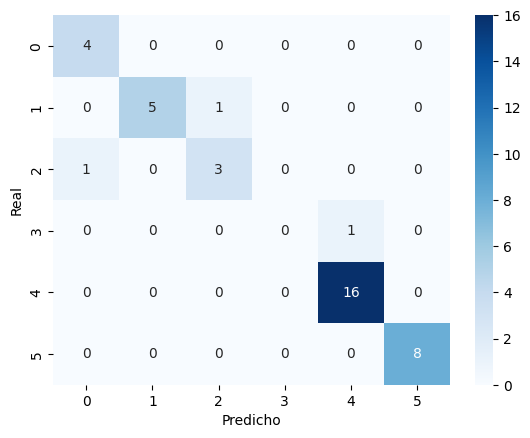

--------------------------------------------------
Metricas de evaluacion de Random Forest:
Accuracy: 0.8205128205128205
Precision: 0.8045584045584045
Recall: 0.8205128205128205
F1: 0.79932964638847
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.67      1.00      0.80         4
           B       0.67      0.33      0.44         6
           F       0.40      0.50      0.44         4
           G       1.00      0.00      0.00         1
           M       1.00      1.00      1.00        16
           O       0.89      1.00      0.94         8

    accuracy                           0.82        39
   macro avg       0.77      0.64      0.61        39
weighted avg       0.83      0.82      0.80        39



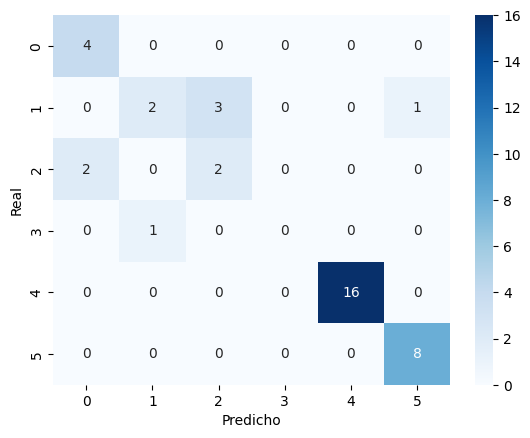

--------------------------------------------------
Metricas de evaluacion de Decision Tree:
Accuracy: 0.7435897435897436
Precision: 0.7496947496947497
Recall: 0.7435897435897436
F1: 0.7401931401931403
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.67      0.50      0.57         4
           B       0.33      0.33      0.33         6
           F       0.43      0.75      0.55         4
           G       1.00      0.00      0.00         1
           M       1.00      1.00      1.00        16
           O       0.86      0.75      0.80         8

    accuracy                           0.74        39
   macro avg       0.71      0.56      0.54        39
weighted avg       0.78      0.74      0.74        39



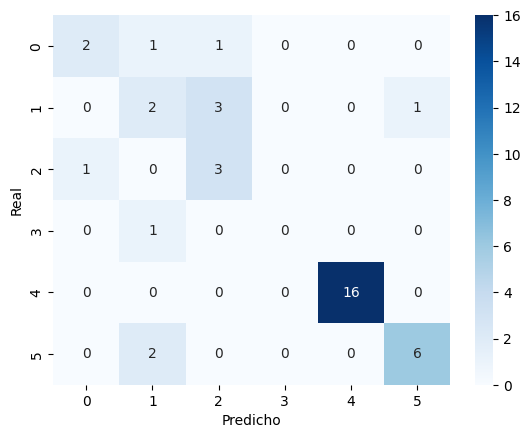

--------------------------------------------------


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Diccionario vacío para guardar los modelos entrenados
modelos_entrenados = {}

# Evaluar accuracy, precision, recall y F1
def obtener_metricas_evaluacion(nombre_modelo, y_real, y_predicho):
    print(f'Metricas de evaluacion de {nombre_modelo}:')
    print("Accuracy:", accuracy_score(y_real, y_predicho))  # Precisión general del modelo
    print("Precision:", precision_score(y_real, y_predicho, average='weighted'))    # Precisión ponderada para todas las clases
    print("Recall:", recall_score(y_real, y_predicho, average='weighted'))  # Sensibilidad o Recall ponderado
    print("F1:", f1_score(y_real, y_predicho, average='weighted'))  # Puntaje F1 ponderado (balance entre precisión y recall)
    
    report = classification_report(y_real, y_predicho, zero_division=1)  # Clasificación detallada (macro y weighted)
    print(f"==> Reporte de Clasificación (macro + weighted):\n{report}")

    # Matriz de confusión
    matrix_confusion = confusion_matrix(y_real, y_predicho)
    sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# Modelos que se van a entrenar
modelos = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(),
    #"Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# Entrenamiento y evaluación de cada modelo
for nombre, modelo in modelos.items():  # Para cada modelo:
    modelo.fit(X_train, y_train)    # Entrenamos el modelo con los datos de entrenamiento
    modelos_entrenados[nombre] = modelo  # Guardamos el modelo entrenado en el diccionario
    
    y_pred = modelo.predict(X_val)  # Generamos predicciones para los datos de validación
    obtener_metricas_evaluacion(nombre, y_val, y_pred)  # Obtenemos las métricas para evaluarlo
    print("-" * 50)

3. Investigar acerca de hiperparámetros de cada modelo, cambiar dos en cada 
uno y probar nuevamente los modelos comparando sus métricas de 
evaluación.

Mejores hiperparámetros para KNN: {'n_neighbors': 5, 'weights': 'distance'}
Métricas de evaluación de KNN:
Accuracy: 0.8974358974358975
Precision: 0.8812803753980223
Recall: 0.8974358974358975
F1: 0.8820543291131526
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.80      1.00      0.89         4
           B       1.00      0.67      0.80         6
           F       0.75      0.75      0.75         4
           G       1.00      0.00      0.00         1
           M       0.94      1.00      0.97        16
           O       0.89      1.00      0.94         8

    accuracy                           0.90        39
   macro avg       0.90      0.74      0.72        39
weighted avg       0.91      0.90      0.88        39



/Users/magalidellapiazza/Library/Python/3.12/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


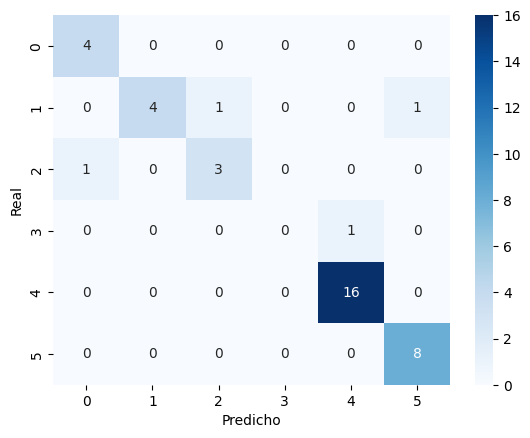

--------------------------------------------------


/Users/magalidellapiazza/Library/Python/3.12/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mejores hiperparámetros para Random Forest: {'max_depth': 10, 'n_estimators': 50}
Métricas de evaluación de Random Forest:
Accuracy: 0.7692307692307693
Precision: 0.7831501831501831
Recall: 0.7692307692307693
F1: 0.768919968919969
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.60      0.75      0.67         4
           B       0.50      0.33      0.40         6
           F       0.29      0.50      0.36         4
           G       1.00      0.00      0.00         1
           M       1.00      1.00      1.00        16
           O       1.00      0.88      0.93         8

    accuracy                           0.77        39
   macro avg       0.73      0.58      0.56        39
weighted avg       0.81      0.77      0.77        39



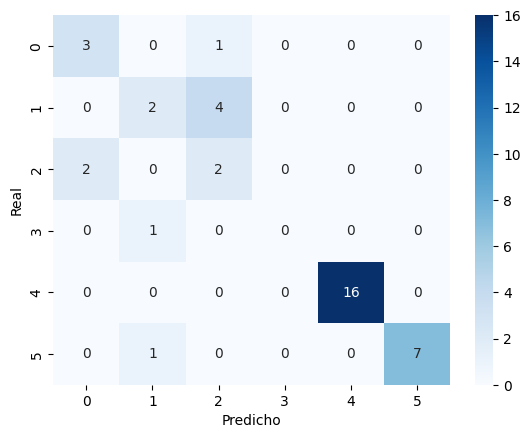

--------------------------------------------------
Mejores hiperparámetros para Decision Tree: {'criterion': 'gini', 'max_depth': 20}
Métricas de evaluación de Decision Tree:
Accuracy: 0.7692307692307693
Precision: 0.7636141636141637
Recall: 0.7692307692307693
F1: 0.7602397602397603
==> Reporte de Clasificación (macro + weighted):
              precision    recall  f1-score   support

           A       0.67      0.50      0.57         4
           B       0.40      0.33      0.36         6
           F       0.43      0.75      0.55         4
           G       1.00      0.00      0.00         1
           M       1.00      1.00      1.00        16
           O       0.88      0.88      0.88         8

    accuracy                           0.77        39
   macro avg       0.73      0.58      0.56        39
weighted avg       0.79      0.77      0.76        39



/Users/magalidellapiazza/Library/Python/3.12/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


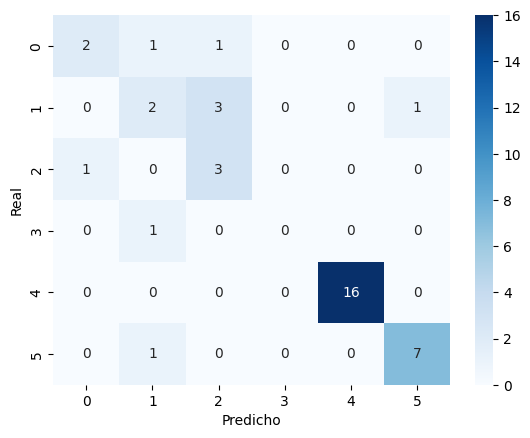

--------------------------------------------------


In [17]:
from sklearn.model_selection import GridSearchCV

# Modelos y hiperparámetros a ajustar (dos por modelo)
param_grid = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [10, 20, None]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10, 20, None],
            "criterion": ["gini", "entropy"]
        }
    }
}

# Definición de función para evaluación de métricas
def obtener_metricas_evaluacion(nombre_modelo, y_real, y_predicho):
    print(f'Métricas de evaluación de {nombre_modelo}:')
    print("Accuracy:", accuracy_score(y_real, y_predicho))
    print("Precision:", precision_score(y_real, y_predicho, average='weighted'))
    print("Recall:", recall_score(y_real, y_predicho, average='weighted'))
    print("F1:", f1_score(y_real, y_predicho, average='weighted'))
    
    report = classification_report(y_real, y_predicho, zero_division=1)
    print(f"==> Reporte de Clasificación (macro + weighted):\n{report}")

    # Matriz de confusión
    matrix_confusion = confusion_matrix(y_real, y_predicho)
    sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# Ajuste de hiperparámetros y evaluación
for nombre, info in param_grid.items():
    # Configuramos GridSearchCV con los hiperparámetros definidos
    grid_search = GridSearchCV(estimator=info["model"], param_grid=info["params"], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Mejora de modelo obtenido después del ajuste
    best_model = grid_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {grid_search.best_params_}")
    
    # Predicción y evaluación del modelo en el conjunto de validación
    y_pred = best_model.predict(X_val)
    obtener_metricas_evaluacion(nombre, y_val, y_pred)
    print("-" * 50)


4. Seleccionar el mejor modelo obtenido, probarlo en el conjunto de testeo y 
comparar las métricas obtenidas respecto al mismo modelo y sus métricas 
obtenidas con el conjunto de validación.

En nuestro caso nos dieron mejor los modelos sin el ajuste de hiperparámetros (los modelos podrían estar haciendo overfitting o underfitting), por lo que decidiremos sobre los modelos sin ajustar:

#### Accuracy
- KNN tiene un Accuracy de 0.92, mientras que Decision Tree tiene un Accuracy de 0.77. Esto nos indica que KNN realiza una mejor predicción general en el conjunto de validación.

#### Precision, Recall y F1-Score
- KNN presenta un **Precision** de 0.90 y un **F1-Score** de 0.91, en comparación con Decision Tree, que tiene valores de Precision y F1-Score alrededor de 0.76.
- La **Recall** también es mejor en KNN (0.92) que en el Decision Tree (0.77).

#### Reporte de Clasificación
- Aunque algunas clases tienen métricas bajas en ambos modelos (como la clase G), el rendimiento de KNN es en general más balanceado en las diferentes clases, lo que se refleja en las métricas globales.

Conclusión: el mejor modelo para comparar es **KNN**.

Métricas de evaluación de KNN en el conjunto de prueba:
Accuracy: 0.7916666666666666
Precision: 0.7668754856254857
Recall: 0.7916666666666666
F1: 0.7632788753799392
==> Reporte de Clasificación (macro + weighted) en el conjunto de prueba:
              precision    recall  f1-score   support

           A       0.50      0.50      0.50         2
           B       0.82      0.90      0.86        10
           F       0.33      0.50      0.40         2
           K       1.00      0.00      0.00         3
           M       0.81      1.00      0.89        21
           O       1.00      0.60      0.75        10

    accuracy                           0.79        48
   macro avg       0.74      0.58      0.57        48
weighted avg       0.83      0.79      0.76        48



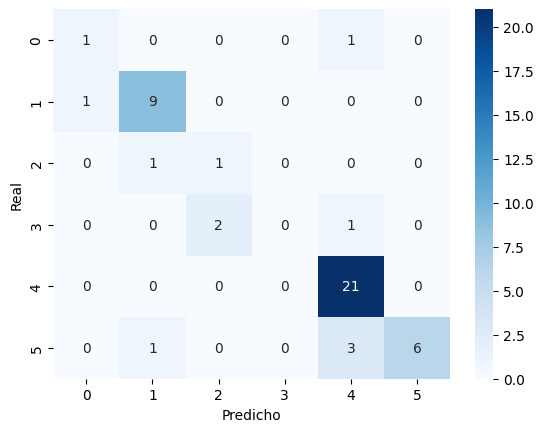

In [18]:
# Usamos el modelo entrenado previamente desde el diccionario 'modelos_entrenados'
mejor_modelo = modelos_entrenados["KNN"]  # Uso el modelo entrenado de KNN

y_pred_test = mejor_modelo.predict(X_test)

# Evaluar las métricas en el conjunto de prueba
print(f'Métricas de evaluación de KNN en el conjunto de prueba:')
print("Accuracy:", accuracy_score(y_test, y_pred_test))  # Precisión general
print("Precision:", precision_score(y_test, y_pred_test, average='weighted'))  # Precisión ponderada
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))  # Recall ponderado
print("F1:", f1_score(y_test, y_pred_test, average='weighted'))  # F1 ponderado

# Reporte de clasificación para el conjunto de prueba
report_test = classification_report(y_test, y_pred_test, zero_division=1)
print(f"==> Reporte de Clasificación (macro + weighted) en el conjunto de prueba:\n{report_test}")

# Matriz de confusión en el conjunto de prueba
matrix_confusion_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix_confusion_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

## Análisis de las métricas

### 1. **Accuracy**:
   - **Validación**: 0.92
   - **Prueba**: 0.79
   - **Interpretación**: Hay una caída considerable en la precisión (accuracy) en el conjunto de prueba, lo que sugiere que el modelo está teniendo dificultades para generalizar fuera del conjunto de entrenamiento y validación. Esta diferencia podría ser una señal de **sobreajuste**, donde el modelo aprende patrones específicos de los datos de entrenamiento y no se adapta bien a nuevos datos.

### 2. **Precision, Recall, y F1**:
   - **Validación**:
     - Precision: 0.90
     - Recall: 0.92
     - F1: 0.91
   - **Prueba**:
     - Precision: 0.77
     - Recall: 0.79
     - F1: 0.76
   - **Interpretación**: La caída en estos valores también es significativa en el conjunto de prueba, especialmente en **precision** y **recall**. Esto podría ser el resultado de un desequilibrio en las clases o de que el modelo no está manejando bien ciertas clases (por ejemplo, en la clase **K**, el modelo tiene una precisión y recall de 0.0). Esto también puede indicar que el modelo no está generalizando bien en clases que son menos representadas en los datos de entrenamiento o que el modelo no está capturando bien las características de los datos en el conjunto de prueba.

### 3. **Clasificación detallada**:
   - **En el conjunto de validación**, el modelo tiene buen rendimiento en clases con más muestras, como **M** y **O**, pero tiene dificultades con clases como **G**, lo cual es esperable.
   - **En el conjunto de prueba**, se observa un desempeño aún peor, especialmente en clases como **A** y **F**. Para algunas clases, como **K**, la precisión es muy baja (0.0), lo que sugiere que el modelo no está prediciendo correctamente estas clases.

---

## Posibles causas y soluciones:

1. **Sobreajuste (Overfitting)**: El modelo tiene un buen desempeño en el conjunto de validación, pero en el conjunto de prueba tiene un rendimiento significativamente peor. Esto puede indicar sobreajuste, donde el modelo ha aprendido demasiado bien los detalles de los datos de entrenamiento, pero no generaliza bien. Algunas soluciones:
   - **Ajuste de hiperparámetros**: Prueba otros valores de `k` en el KNN o cambia el parámetro `weights` (por ejemplo, usando `'uniform'` en lugar de `'distance'`).
   - **Regularización**: Prueba regularización (si es posible) para evitar que el modelo se sobreajuste.
   - **Aumentar datos de entrenamiento**: Si tienes pocas muestras de ciertas clases, aumentar el número de ejemplos de entrenamiento para esas clases podría ayudar.

2. **Desequilibrio de clases**: El modelo parece tener dificultades con clases con pocos ejemplos, como **K** y **A**. Podrías intentar:
   - **Rebalanceo de clases**: Usar técnicas como sobremuestreo (SMOTE) o submuestreo de clases.
   - **Cambiar el método de clasificación**: Considerar otros modelos más robustos frente a clases desbalanceadas (por ejemplo, Random Forest o un modelo basado en árboles de decisión con ajuste para clases desbalanceadas).

3. **Evaluación de modelos adicionales**: Aunque KNN es un buen modelo, puede que no sea el más adecuado para este conjunto de datos. Podrías considerar probar otros modelos como **Random Forest** o **Support Vector Machines**, que tienden a manejar mejor el sobreajuste y los desequilibrios de clases.

---

## Comparación y acción:

Puedes comparar estos resultados con otros modelos para verificar si el desempeño en el conjunto de prueba sigue siendo bajo solo para KNN o si ocurre lo mismo con otros modelos. Esto te ayudará a identificar si el problema es inherente al modelo KNN o si se debe a características de los datos, como el desequilibrio de clases o la falta de generalización.

Si decides continuar con KNN, prueba:
- Cambiar `k` (por ejemplo, probar `k=3` o `k=7`).
- Probar otras técnicas de preprocesamiento de datos (como escalado o normalización).
- Experimentar con diferentes estrategias de ajuste de pesos.

---

## Resumen:

La caída en las métricas de prueba sugiere que el modelo necesita ajustes, ya sea en la forma en que está siendo entrenado o en el modelo mismo.
